In [16]:
import mlrose_hiive as mlrose
import numpy as np
from mlrose_hiive import GeomDecay
import pandas as pd
import matplotlib.pyplot as plt
from dataclasses import dataclass
import random


In [17]:
def bipartite_max(arr):
    assert type(arr) == np.ndarray
    tot = 0
    half_size = len(arr)//2
    tot += np.sum(arr[:half_size-1] != arr[1:half_size])
    tot += np.sum(arr[:half_size] != arr[half_size:])
    return tot

# Initialize custom fitness function object
fitness = mlrose.CustomFitness(bipartite_max)

In [18]:
length = 1000
init_state = np.random.randint(2, size=length)
def get_random_result_mean():
    results = []
    for _ in range(10000):
        init_state = np.random.randint(2, size=length)
        results.append(fitness.evaluate(init_state))
    return np.mean(results)
def get_optimal_result():
    return length - 1
problem = mlrose.DiscreteOpt(length = length, fitness_fn = fitness, max_val = 2)
print(f"{get_random_result_mean()=}")
print(f"{get_optimal_result()=}")


get_random_result_mean()=499.5926
get_optimal_result()=999


In [49]:
%%timeit
fitness.evaluate(np.array([1]*length))

42.3 µs ± 40.8 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


## tuning genetic algorithms

(200, .5, .7) performs best

In [19]:
np.random.seed(2)
random.seed(2)

def get_tuned_genetic_alg(pop_size=200, mutation_prob=.1, max_iters=100_000, pop_breed_percent=.75, max_attempts=1000):
    return mlrose.genetic_alg(problem, pop_size=pop_size, pop_breed_percent=pop_breed_percent, mutation_prob=mutation_prob, max_iters=max_iters, max_attempts=max_attempts)

pop_sizes = [50, 200]
mutation_probs = [.1, .5]
pop_breed_percent = [.7, .9]

d3 = {
    (p, m, b): np.mean([get_tuned_genetic_alg(pop_size=p, mutation_prob=m, pop_breed_percent=b)[1] for _ in range(4)])
    for p in pop_sizes
    for m in mutation_probs
    for b in pop_breed_percent
}

d3

{(50, 0.1, 0.7): 900.25,
 (50, 0.1, 0.9): 899.75,
 (50, 0.5, 0.7): 921.75,
 (50, 0.5, 0.9): 910.25,
 (200, 0.1, 0.7): 911.0,
 (200, 0.1, 0.9): 890.75,
 (200, 0.5, 0.7): 923.5,
 (200, 0.5, 0.9): 900.75}

In [39]:
[(k, v) for k, v in sorted(d3.items(), key = lambda x: -x[1])]

[((200, 0.5, 0.7), 923.5),
 ((50, 0.5, 0.7), 921.75),
 ((200, 0.1, 0.7), 911.0),
 ((50, 0.5, 0.9), 910.25),
 ((200, 0.5, 0.9), 900.75),
 ((50, 0.1, 0.7), 900.25),
 ((50, 0.1, 0.9), 899.75),
 ((200, 0.1, 0.9), 890.75)]

In [ ]:
np.random.seed(2)
random.seed(2)
long_SA_res = [mlrose.simulated_annealing(
    problem,
    max_attempts=100_000,
    schedule=GeomDecay(init_temp=.5, decay=.999999, min_temp=0.001),
    max_iters=1_000_000
)[1] for _ in range(4)]
long_SA_res

In [ ]:
get_tuned_genetic_alg(pop_size=200, mutation_prob=.5, pop_breed_percent=.7)

## tuning SA

(.5, .99999) performs best

In [20]:
np.random.seed(2)
random.seed(2)
get_tuned_sa = lambda init_temp, decay: mlrose.simulated_annealing(
    problem,
    max_attempts=10_000,
    schedule=GeomDecay(init_temp=init_temp, decay=decay, min_temp=0.001),
    max_iters=100_000
)
init_temps = [1, .5, .1]
decays = [.999, .9999, .99999, .999999]
d = {(t, d): np.mean([get_tuned_sa(t, d)[1] for _ in range(4)]) for t in init_temps for d in decays}
d

{(1, 0.999): 918.0,
 (1, 0.9999): 943.5,
 (1, 0.99999): 919.75,
 (1, 0.999999): 748.75,
 (0.5, 0.999): 916.75,
 (0.5, 0.9999): 927.75,
 (0.5, 0.99999): 957.75,
 (0.5, 0.999999): 901.25,
 (0.1, 0.999): 914.5,
 (0.1, 0.9999): 906.25,
 (0.1, 0.99999): 912.25,
 (0.1, 0.999999): 912.0}

In [41]:
[(k, v) for k, v in sorted(d.items(), key = lambda x: -x[1])]


[((0.5, 0.99999), 957.75),
 ((1, 0.9999), 943.5),
 ((0.5, 0.9999), 927.75),
 ((1, 0.99999), 919.75),
 ((1, 0.999), 918.0),
 ((0.5, 0.999), 916.75),
 ((0.1, 0.999), 914.5),
 ((0.1, 0.99999), 912.25),
 ((0.1, 0.999999), 912.0),
 ((0.1, 0.9999), 906.25),
 ((0.5, 0.999999), 901.25),
 ((1, 0.999999), 748.75)]

We can actually do better, but it takes a long time to run so we didn't want to include it in experiments that involve running it multiple times so we could get some work done.

In [21]:
np.random.seed(2)
random.seed(2)
long_SA_res = [mlrose.simulated_annealing(
    problem,
    max_attempts=100_000,
    schedule=GeomDecay(init_temp=.5, decay=.999999, min_temp=0.001),
    max_iters=1_000_000
)[1] for _ in range(4)]
long_SA_res


[976.0, 981.0, 976.0, 970.0]

In [45]:
np.mean(long_SA_res)

975.75

## checking rhc

In [44]:
np.random.seed(2)
random.seed(2)
rhc_trials = [mlrose.random_hill_climb(problem, max_attempts=10_000, max_iters=100_000)[1] for _ in range(100)]
print(f"{np.mean(rhc_trials)=}")
print(f"{np.max(rhc_trials)=}")
print(f"{np.min(rhc_trials)=}")
print(f"{np.median(rhc_trials)=}")

np.mean(rhc_trials)=912.57
np.max(rhc_trials)=930.0
np.min(rhc_trials)=890.0
np.median(rhc_trials)=913.0


In [23]:
class RunResult:
    def __init__(self, raw_result, eval_groups, time_groups):
        """
        eval_groups is size of groups for evals, so if 1000 then 0-999 is one group, 1000-1999 is another, etc.
        time_groups is same, grouped by milliseconds.
        """
        scores, evals, times = raw_result[-1].T
        scores, evals = scores.astype(int), evals.astype(int)
        times_ms = (times * 1000).astype(int)
        grouped_evals = evals // eval_groups * eval_groups
        grouped_times = times_ms // time_groups * time_groups
        scores = scores
        # make a dataframe that has index of the grouped_evals, value is min of scores, group by evals
        df_evals = pd.DataFrame({"grouped_evals": grouped_evals, "scores": scores})
        self.df_evals = df_evals.groupby("grouped_evals").min()

        df_times = pd.DataFrame({"grouped_times": grouped_times, "scores": scores})
        self.df_times = df_times.groupby("grouped_times").min()

In [35]:
np.random.seed(2)
random.seed(2)

@dataclass
class EvalTimeStats:
    agg_eval_df: pd.DataFrame
    agg_time_df: pd.DataFrame

class RunResults:
    def __init__(self, run_count: int, ms_groupings=20):
        self.run_count = run_count
        self.ms_groupings = ms_groupings

        self.rhc_fn = lambda: mlrose.random_hill_climb(problem, curve=True, max_attempts=100_000, max_iters=100_000)
        rhc_results = self.get_results(self.rhc_fn, self.run_count)
        self.rhc_stats = self.get_eval_time_stats([RunResult(rhc_result, 1000, self.ms_groupings) for rhc_result in rhc_results])

        self.sa_fn = lambda: mlrose.simulated_annealing(
            problem,
            max_attempts=10_000,
            schedule=GeomDecay(init_temp=.5, decay=0.99999, min_temp=0.001),
            curve=True,
            max_iters=100_000
        )
        sa_results = self.get_results(self.sa_fn, self.run_count)
        self.sa_stats = self.get_eval_time_stats([RunResult(sa_result, 1000, self.ms_groupings) for sa_result in sa_results])

        self.ga_fn = lambda: mlrose.genetic_alg(problem, curve=True, pop_size=200, mutation_prob=.5, pop_breed_percent=.7, max_iters=100_000, max_attempts=1000)
        ga_results = self.get_results(self.ga_fn, self.run_count)
        self.ga_stats = self.get_eval_time_stats([RunResult(ga_result, 1000, self.ms_groupings) for ga_result in ga_results])

    def get_results(self, fn, count):
        results = []
        for _ in range(count):
            results.append(fn())
        return results
    
    def get_eval_time_stats(self, run_results: list[RunResult]) -> EvalTimeStats:
        combined_evals = pd.concat([run_result.df_evals for run_result in run_results], axis=1)
        combined_times = pd.concat([run_result.df_times for run_result in run_results], axis=1)
        # filter agg_eval_df to only go up to index of 100,000
        agg_eval_df = pd.DataFrame({
            "min": combined_evals.min(axis=1),
            "median": combined_evals.median(axis=1),
            "max": combined_evals.max(axis=1)
        }).sort_index().loc[:100_000]
        agg_time_df = pd.DataFrame({
            "min": combined_times.min(axis=1),
            "median": combined_times.median(axis=1),
            "max": combined_times.max(axis=1)
        }).sort_index().loc[:4000]
        return EvalTimeStats(agg_eval_df, agg_time_df)
    
    def plot_evals(self):
        sa_eval_df = self.sa_stats.agg_eval_df
        rhc_eval_df = self.rhc_stats.agg_eval_df
        ga_eval_df = self.ga_stats.agg_eval_df

        plt.figure(figsize=(5.5, 4))
        plt.plot(sa_eval_df.index, sa_eval_df['median'], label='Simulated Annealing', color='blue')
        plt.fill_between(sa_eval_df.index, sa_eval_df['min'], sa_eval_df['max'], color='blue', alpha=0.2)
        plt.plot(rhc_eval_df.index, rhc_eval_df['median'], label='Random Hill Climbing', color='red')
        plt.fill_between(rhc_eval_df.index, rhc_eval_df['min'], rhc_eval_df['max'], color='red', alpha=0.2)
        plt.plot(ga_eval_df.index, ga_eval_df['median'], label='Genetic Algorithm', color='green')
        plt.fill_between(ga_eval_df.index, ga_eval_df['min'], ga_eval_df['max'], color='green', alpha=0.2)
        plt.axhline(y=999, color='black', linestyle='--', label='Optimal Solution')
        plt.title('K-color Performance Metrics by Fitness Evaluations')
        plt.xlabel('Count of Evaluations')
        plt.ylabel('Fitness')
        plt.legend()
        plt.grid(True)
        # save figure
        plt.savefig('k-color_evals.png')
        plt.show()

    def plot_times(self):
        sa_time_df = self.sa_stats.agg_time_df
        rhc_time_df = self.rhc_stats.agg_time_df
        ga_time_df = self.ga_stats.agg_time_df

        plt.figure(figsize=(5.5, 4))
        plt.plot(sa_time_df.index, sa_time_df['median'], label='Simulated Annealing', color='blue')
        plt.fill_between(sa_time_df.index, sa_time_df['min'], sa_time_df['max'], color='blue', alpha=0.2)
        plt.plot(rhc_time_df.index, rhc_time_df['median'], label='Random Hill Climbing', color='red')
        plt.fill_between(rhc_time_df.index, rhc_time_df['min'], rhc_time_df['max'], color='red', alpha=0.2)
        plt.plot(ga_time_df.index, ga_time_df['median'], label='Genetic Algorithm', color='green')
        plt.fill_between(ga_time_df.index, ga_time_df['min'], ga_time_df['max'], color='green', alpha=0.2)
        # add a horizontal line at 999 to indicate the optimal possible solution
        plt.axhline(y=999, color='black', linestyle='--', label='Optimal Solution')
        plt.title('K-color Performance Metrics by Time')
        plt.xlabel('Time (ms)')
        plt.ylabel('Fitness')
        plt.legend()
        plt.grid(True)
        # save figure
        plt.savefig('k-color_time.png')
        plt.show()
    
res = RunResults(5)

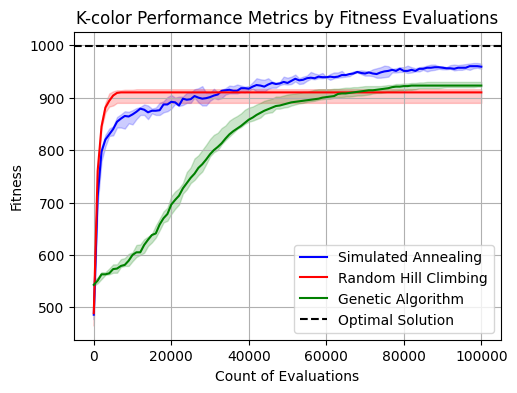

In [36]:
res.plot_evals()

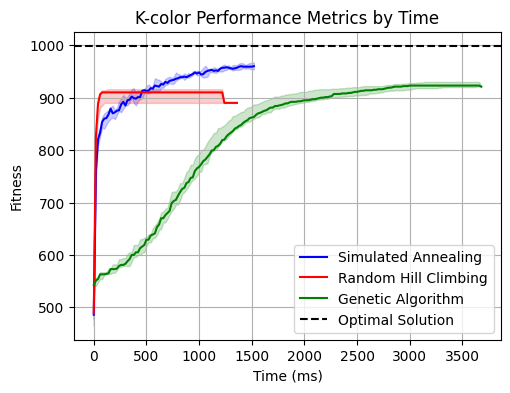

In [37]:
res.plot_times()

In [27]:
res.ga_stats

EvalTimeStats(agg_eval_df=               min  median  max
grouped_evals                  
0              541   543.0  551
1000           546   551.0  557
2000           554   563.0  567
3000           562   563.0  567
4000           563   565.0  574
...            ...     ...  ...
96000          920   923.0  930
97000          920   923.0  930
98000          920   923.0  930
99000          921   923.0  930
100000         921   923.0  930

[101 rows x 3 columns], agg_time_df=                 min  median    max
grouped_times                      
0              541.0   543.0  551.0
20             541.0   551.0  557.0
40             548.0   554.0  557.0
60             554.0   563.0  567.0
80             557.0   563.0  567.0
...              ...     ...    ...
3600           920.0   921.0  922.0
3620           920.0   920.0  920.0
3640           921.0   921.0  921.0
3660           921.0   921.0  921.0
3680           921.0   921.0  921.0

[185 rows x 3 columns])

In [28]:
res.sa_stats

EvalTimeStats(agg_eval_df=               min  median  max
grouped_evals                  
0              477   486.0  517
1000           696   712.0  745
2000           779   797.0  806
3000           807   820.0  829
4000           827   830.0  841
...            ...     ...  ...
96000          955   957.0  964
97000          953   960.0  965
98000          956   960.0  966
99000          957   960.0  966
100000         955   959.0  965

[101 rows x 3 columns], agg_time_df=                 min  median    max
grouped_times                      
0              477.0   486.0  517.0
20             752.0   763.0  783.0
40             813.0   820.0  829.0
60             827.0   833.0  845.0
80             843.0   850.0  863.0
...              ...     ...    ...
1440           955.0   959.0  963.0
1460           955.0   959.0  966.0
1480           954.0   959.0  966.0
1500           956.0   962.0  966.0
1520           957.0   957.0  957.0

[77 rows x 3 columns])

In [29]:
res.rhc_stats

EvalTimeStats(agg_eval_df=               min  median  max
grouped_evals                  
0              465   489.0  516
1000           750   760.0  765
2000           842   845.0  854
3000           872   881.0  890
4000           883   894.0  908
...            ...     ...  ...
96000          890   910.0  916
97000          890   910.0  916
98000          890   910.0  916
99000          890   910.0  916
100000         890   910.0  916

[101 rows x 3 columns], agg_time_df=                 min  median    max
grouped_times                      
0              465.0   489.0  516.0
20             811.0   830.0  847.0
40             863.0   889.0  899.0
60             885.0   908.0  912.0
80             889.0   910.0  914.0
...              ...     ...    ...
1140           890.0   910.0  916.0
1160           890.0   910.0  916.0
1180           890.0   910.0  916.0
1200           890.0   910.0  916.0
1220           890.0   890.0  890.0

[62 rows x 3 columns])